In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
thresh = 0.75 # neuronal threshold
lens = thresh # hyper-parameters of approximate function
decay = 0.2 # decay constants
# num_classes = 10
batch_size  = 1
learning_rate = 1e-3
# learning_rate = 1e-3 # default
num_epochs = 10000 # max epoch
rest = -0.1
# define approximate firing function
class ActFun(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(thresh).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - thresh) <= lens
        temp2 = input - thresh > lens
#         temp = input >= 0
        grad_pos = grad_input > 0
        grad_neg = grad_input < 0
#         is_spike = input >= thresh - 0.25 #inhibit
        is_spike = input >= thresh
        is_not_spike = input < thresh #enforce

#         return grad_input * (1.0 + is_spike.float()) * temp.float()
#         return grad_input * (grad_neg.float() * (1. + is_spike.float() * temp.float()) + grad_pos.float() * (1+is_spike.float()))
#       *  return grad_input * ((1.0 + is_spike.float()) * temp.float() + grad_pos.float() * temp2.float() * 0.2)
        var = thresh * thresh
        return grad_input * ( grad_pos * torch.exp( -(input -thresh) * (input -thresh) / (2*var)) / (2*math.pi*var)**0.5 
                             + grad_neg * torch.exp( -(input -0) * (input -0) / (2*var)) / (2*math.pi*var)**0.5 )
    
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
 
    def forward(self, x):
        x = x * torch.sigmoid(10*x)
        return x



act_fun = ActFun.apply
# membrane potential update
def mem_update(fc_input, x, mem, spike, fc_self):
#     mem = mem * decay * (1. - spike) + spike * rest + fc_input(x)
#     mem = torch.Tensor([[fc_self(mem_i.unsqueeze(0)) for mem_i in mem[bch]] for bch in range(batch_size)]) * (1. - spike) + spike * rest + fc_input(x)
#     mem_t = fc_self(mem.clone().reshape(-1,1)).reshape(batch_size,-1) * (1. - spike) + spike * rest + fc_input(x)
#     mem = fc_self(mem.unsqueeze(-1)).squeeze(-1) * (1. - spike) + spike * rest + fc_input(x)
#     mem_t = fc_self(mem.clone().reshape(-1,1)).reshape(batch_size,-1) * (1. - spike) + fc_input(x)
#     mem_t = mem * decay * (1. - spike) + rest * spike + fc_input(x)
    mem_t = mem * decay * (1. - spike)  + fc_input(x)
    spike = act_fun(mem_t) # act_fun : approximation firing function
    return mem_t, spike


# # cnn_layer(in_planes, out_planes, stride, padding, kernel_size)
# cfg_cnn = [(1, 32, 1, 1, 3),
#            (32, 32, 1, 1, 3),]
# # kernel size
# cfg_kernel = [28, 14, 7]
# fc layer
n_input = 620
n_classes = 11
n_hidden1 = 400
n_hidden2 = 620
cfg_fc = [n_input, n_hidden1, n_hidden2, n_classes]

# Dacay learning_rate
def lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=50):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    if epoch % lr_decay_epoch == 0 and epoch > 1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5
    return optimizer

class SNN2(nn.Module):
    def __init__(self, max_time=50):
        super(SNN2, self).__init__()
#         in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[0]
#         self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
#         in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[1]
#         self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)

#         self.fc1 = nn.Linear(cfg_kernel[-1] * cfg_kernel[-1] * cfg_cnn[-1][1], cfg_fc[0])
        self.fc1 = nn.Sequential(
#             nn.Linear(cfg_fc[0], cfg_fc[1]),
            nn.Linear(cfg_fc[0], cfg_fc[2], bias=False),
            Swish()
#             nn.Sigmoid()
        )
        self.fc2 = nn.Sequential(
#             nn.Linear(cfg_fc[1], cfg_fc[2]),
            nn.Linear(cfg_fc[2], cfg_fc[3], bias=False),
            Swish()
#             nn.Sigmoid()
        )
        self.max_time = max_time
        self.fc_neuron_para = nn.Sequential(
                nn.Linear(1,1,bias=False),
                nn.ReLU()
        )
        
    def forward(self, input):
#         c1_mem = c1_spike = torch.zeros(batch_size, cfg_cnn[0][1], cfg_kernel[0], cfg_kernel[0], device=device)
#         c2_mem = c2_spike = torch.zeros(batch_size, cfg_cnn[1][1], cfg_kernel[1], cfg_kernel[1], device=device)

        time_window = self.max_time
        h1_mem = h1_spike = h1_sumspike = torch.zeros(batch_size, cfg_fc[2], device=device)
        h2_mem = h2_spike = h2_sumspike = torch.zeros(batch_size, cfg_fc[3], device=device)

        for step in range(time_window): # simulation time steps
            x = input[:,step]
            h1_mem, h1_spike = mem_update(self.fc1, x, h1_mem, h1_spike, self.fc_neuron_para)
            h2_mem, h2_spike = mem_update(self.fc2, h1_spike, h2_mem, h2_spike, self.fc_neuron_para)
            h2_sumspike += h2_spike

        outputs = h2_sumspike / 130
        return outputs

class SNN1(nn.Module):
    def __init__(self, max_time=50):
        super(SNN1, self).__init__()

        self.fc2 = nn.Sequential(
            nn.Linear(cfg_fc[0], cfg_fc[-1], bias = False),
#             custom_fc(cfg_fc[0], cfg_fc[-1]),
            nn.ReLU()
#             nn.Sigmoid()
        )
        self.max_time = max_time
        self.fc_neuron_para = nn.Sequential(
                nn.Linear(1,1,bias=False),
                nn.ReLU()
        )
        
    def forward(self, input):

        time_window = self.max_time
#         h1_mem = h1_spike = h1_sumspike = torch.zeros(batch_size, cfg_fc[1], device=device)
        h2_mem = h2_spike = h2_sumspike = torch.zeros(batch_size, cfg_fc[-1], device=device)

        for step in range(time_window): # simulation time steps
            x = input[:,step]
            h2_mem, h2_spike = mem_update(self.fc2, x, h2_mem, h2_spike, self.fc_neuron_para)
            h2_sumspike += h2_spike

        outputs = h2_sumspike / 50
        return outputs

    
class SNN3(nn.Module):
    def __init__(self, max_time=50):
        super(SNN3, self).__init__()
#         in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[0]
#         self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
#         in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[1]
#         self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)

#         self.fc1 = nn.Linear(cfg_kernel[-1] * cfg_kernel[-1] * cfg_cnn[-1][1], cfg_fc[0])
        self.fc1 = nn.Sequential(
            nn.Linear(cfg_fc[0], cfg_fc[1], bias=False),
            Swish()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(cfg_fc[1], cfg_fc[2], bias=False),
            Swish()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(cfg_fc[2], cfg_fc[3], bias=False),
            Swish()
        )
        self.max_time = max_time
        self.fc_neuron_para = nn.Sequential(
                nn.Linear(1,1,bias=False),
                nn.ReLU()
        )
        
    def forward(self, input):

        time_window = self.max_time
        h1_mem = h1_spike = h1_sumspike = torch.zeros(batch_size, cfg_fc[1], device=device)
        h2_mem = h2_spike = h2_sumspike = torch.zeros(batch_size, cfg_fc[2], device=device)
        h3_mem = h3_spike = h3_sumspike = torch.zeros(batch_size, cfg_fc[3], device=device)

        for step in range(time_window): # simulation time steps
            x = input[:,step]
            h1_mem, h1_spike = mem_update(self.fc1, x, h1_mem, h1_spike, self.fc_neuron_para)
            h2_mem, h2_spike = mem_update(self.fc2, h1_spike, h2_mem, h2_spike, self.fc_neuron_para)
            h3_mem, h3_spike = mem_update(self.fc3, h2_spike, h3_mem, h3_spike, self.fc_neuron_para)
            h3_sumspike += h3_spike

        outputs = h3_sumspike / 50
        return outputs
    
class SNN4(nn.Module):
    def __init__(self, max_time=50):
        super(SNN4, self).__init__()

        self.fc2 = nn.Sequential(
            nn.Linear(cfg_fc[0], cfg_fc[-1], bias = False),
            nn.ReLU()
        )
        self.max_time = max_time
        
        self.h1 = None
        self.h2_spike_l = None
        self.h2_mem_l = None
        
        
        self.CW = 5 # Kernel effect window size
        
    def forward(self, input):

        time_window = self.max_time
        
        
        self.h1 = torch.zeros(batch_size, time_window, cfg_fc[-1], device=device).float()
        self.h2_spike_l = torch.zeros(batch_size, time_window, cfg_fc[-1], device=device).float()
        self.h2_mem_l = torch.zeros(batch_size, time_window, cfg_fc[-1], device=device).float()
        
        h2_spike = torch.zeros(batch_size, cfg_fc[-1], device=device)
        h2_sumspike = torch.zeros(batch_size, cfg_fc[-1], device=device)
        
        

        for t in range(time_window): # simulation time steps
            x = input[:,t]
            self.h1[:,t] = self.fc2(x)
#             print(f't={t}:{self.h1[:,t]}')
            
#             h2_mem = torch.zeros(batch_size, cfg_fc[-1], device=device)
        
            for t_k in range(self.CW):
                if t - t_k >= 0:
                    self.h2_mem_l[:,t] += self.K(t_k) * self.h1[:, t-t_k] - self.K_spike(t_k) * self.h2_spike_l[:, t-t_k]
                    
            h2_spike = act_fun(self.h2_mem_l[:,t].clone())
            
            self.h2_spike_l[:,t] = h2_spike * (self.h2_mem_l[:,t].clone())

        
#             h2_mem, h2_spike = mem_update(self.fc2, x, h2_mem, h2_spike, self.fc_neuron_para)
            h2_sumspike += h2_spike
    
        outputs = h2_sumspike / 50
        return outputs
    
    # define effect window [0,CW)
    def K(self, t0):
        t_s = 1 #time constant
        
#         return math.exp(-t0/t_s)
        
        if(t0 < 0):
            return 0
        
        t = t0 - int(self.CW/2)
        
        if(t < 0):
            return -0.5 * math.exp(t/(t_s/2))

        return math.exp(-t/t_s)
    
    def K_spike(self, t0):
        t_s = 1 #time constant
        return math.exp(-t0/t_s)

def init_weights(m):
    if type(m) == nn.Linear:
        print("init")
        torch.nn.init.xavier_normal_(m.weight)
#         torch.nn.init.uniform_(m.weight, -0.2, 0.2)

class custom_fc(nn.Module):
    def __init__(self, n_input, n_output):
        super(custom_fc,self).__init__()
#         self.params = nn.ParameterList([nn.Parameter(torch.randn(4,4)) for i in range(4)])
#         self.params.append(nn.Parameter(torch.randn(4,1)))
        
        self.params = nn.Parameter(torch.zeros(1, n_input, n_output))
#         self.params.unsqueeze(0)
        
#         self.params += 0.01
        torch.nn.init.normal_(self.params, mean=-1.0, std=1)
        print(self.params.shape)
        print(self.params)

    def forward(self,x):
        
        # [batch, n_input]
        x = x.unsqueeze(1)
        
        # [batch, 1, n_input]
        
        
        
        x = torch.bmm(x, F.sigmoid(self.params))
            
        # [batch, 1, n_output]
        x = x.squeeze(1)
#         print(x)
        return x

-0.00915781944436709
-0.06766764161830635
1.0
0.36787944117144233
0.1353352832366127


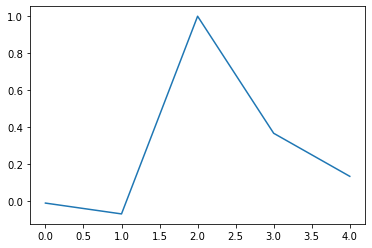

In [10]:
import matplotlib.pyplot as plt
import numpy as np
test_net = SNN4(50)
test_net.CW = 5
test_k_l = []
for t in range(test_net.CW):
    test_k_l.append(test_net.K(t))
    print(test_net.K(t))
x = range(test_net.CW)
plt.plot(x, [test_net.K(t) for t in x])

In [11]:
test = torch.arange(1, 23, device=device)
test = test.reshape(1,-1)
test[0][-2] = test[0][-1]
test[0][1] = 0
test[0][0] = 1
test[0][20] = -1
test[0][21] = -1
print(test)

w, predicted = test.cpu().min(1)
predicted

tensor([[ 1,  0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, -1, -1]])


tensor([20])

In [12]:
##### Load Train Dataset ##### 
from scipy.io import loadmat 
import numpy as np
m = loadmat("./Spike TIDIGITS/Spike-TIDIGITS.mat")
max_time = 130 #ms
input_neuron_num = 620
input_comb_coef = 10
train_data_num = m['train_pattern'].shape[0]
train_datasets = np.zeros((train_data_num, max_time, int(input_neuron_num/1)))
for i in range(train_data_num):
    current_array = m['train_pattern'][i][0]
    current_spikes_input = np.zeros((max_time, int(input_neuron_num/1)))
    for input_idx in range(current_array.shape[0]):
        for spike_time in current_array[input_idx]:
            if spike_time < max_time:
                current_spikes_input[int(spike_time)][int(input_idx/1)] = 1
    train_datasets[i] = current_spikes_input
train_datasets = torch.Tensor(train_datasets).byte()
train_labels = torch.LongTensor(m['train_labels']-1)

In [13]:
##### Load Test Dataset ##### 
# m = loadmat("./Spike TIDIGITS/Spike-TIDIGITS.mat")
# max_time = 50 #ms
# input_neuron_num = 620
test_data_num = m['test_pattern'].shape[0]
test_datasets = np.zeros((test_data_num, max_time, input_neuron_num))
for i in range(test_data_num):
    current_array = m['test_pattern'][i][0]
    current_spikes_input = np.zeros((max_time, input_neuron_num))
    for input_idx in range(current_array.shape[0]):
        for spike_time in current_array[input_idx]:
            if spike_time < max_time:
                current_spikes_input[int(spike_time)][input_idx] = 1
    test_datasets[i] = current_spikes_input
test_datasets = torch.Tensor(test_datasets).byte()
test_labels = torch.LongTensor(m['test_labels']-1)
n_test = test_labels.shape[0]

In [14]:
train_data_num
test_data_num
for input in train_datasets:
    if(torch.sum(input) == 0.):
        print(1)
for test_sample in test_datasets:
    if(torch.sum(test_sample) == 0.):
        print(1)
print(train_datasets.shape)
print(train_labels.shape)
print(test_datasets.shape)
print(test_labels.shape)

torch.Size([2464, 130, 620])
torch.Size([2464, 1])
torch.Size([2486, 130, 620])
torch.Size([2486, 1])


In [24]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun  9 09:46:25 2018

@author: yjwu

Python 3.5.2

"""

from __future__ import print_function
import torchvision
import torchvision.transforms as transforms
import os
import time
# os.environ['CUDA_VISIBLE_DEVICES'] = "3"
# names = 'spiking_model'
# data_path =  './raw/' #todo: input your data path
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_dataset = torchvision.datasets.MNIST(root= data_path, train=True, download=True, transform=transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# test_set = torchvision.datasets.MNIST(root= data_path, train=False, download=True,  transform=transforms.ToTensor())
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
acc_record = list([])
loss_train_record = list([])
loss_test_record = list([])


snn = SNN2(max_time)
snn.to(device)
snn = snn.apply(init_weights)
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    running_loss = 0
    start_time = time.time()
    total = 0
    correct = 0
    
    for step, input_data in enumerate(train_datasets):
        labels = train_labels[step].unsqueeze(0)
    
        snn.zero_grad()
        optimizer.zero_grad()

        input_data = input_data.float().to(device)
        input_data = input_data.unsqueeze(0)
        
        outputs = snn(input_data)
        
        _, predicted = outputs.cpu().max(1)
        total += float(labels.size(0))
        correct += float(predicted.eq(labels).sum().item())
        
        labels_ = torch.zeros(batch_size, n_classes).scatter_(1, labels.view(-1, 1), 1)
        loss = criterion(outputs.cpu(), labels_)
#         loss = criterion(outputs.cpu(), labels.reshape(-1))
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if (step+1)%800 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.5f'
                    %(epoch+1, num_epochs, step+1, train_datasets.shape[0]//batch_size,running_loss ))
            running_loss = 0
            print('Accuracy:', correct/total )
            print('Time elasped:', time.time()-start_time)
            correct = 0
            total = 0
            
    correct = 0
    total = 0
    optimizer = lr_scheduler(optimizer, epoch, learning_rate, 10)
    loss_total = 0

    with torch.no_grad():
        for step, test_data in enumerate(test_datasets):
            test_label = test_labels[step].unsqueeze(0)
            test_data = test_data.float().to(device).unsqueeze(0)
            
            optimizer.zero_grad()
            outputs = snn(test_data)
            labels_ = torch.zeros(batch_size, n_classes).scatter_(1, test_label.view(-1, 1), 1)
            loss = criterion(outputs.cpu(), labels_)
#             loss = criterion(outputs.cpu(), test_label.reshape(-1))
            _, predicted = outputs.cpu().max(1)
#             if float(predicted.eq(test_label).sum().item()) == 0:
#                 print(f'Test_idx: {step}   Incorrectly predict {predicted} with true label {test_label}')
            total += float(test_label.size(0))
            correct += float(predicted.eq(test_label).sum().item())
            loss_total += loss.item()
#             print(f'predicted: {predicted}, float(test_label.size(0)): {float(test_label.size(0))}, float(predicted.eq(test_label).sum().item()), {float(predicted.eq(test_label).sum().item())}')
#             if step % 100 == 0:
#             if step == test_datasets.shape[0]-1:
#                 acc = 100. * float(correct) / float(total)
#                 print(step, test_datasets.shape[0],' Acc: %.5f' % acc)

        print('Iters:', epoch)
        print('Test Accuracy on test dataset: %.3f' % (100 * correct / total))
        print('Test Loss on test dataset: %.3f' % (loss_total))
        acc = 100. * float(correct) / float(total)
        acc_record.append(acc)
        loss_test_record.append(loss_total)
        print('Time elasped:', time.time()-start_time)
        print('\n\n\n')
#     if epoch % 5 == 0:
#         print(acc)
#         print('Saving..')
#         state = {
#             'net': snn.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#             'acc_record': acc_record,
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, './checkpoint/ckpt' + names + '.t7')
#         best_acc = acc

init
init
init
Epoch [1/10000], Step [800/2464], Loss: 65.10170
Accuracy: 0.3725
Time elasped: 137.18256306648254
Epoch [1/10000], Step [1600/2464], Loss: 60.22939
Accuracy: 0.77625
Time elasped: 274.36621260643005
Epoch [1/10000], Step [2400/2464], Loss: 58.58120
Accuracy: 0.85
Time elasped: 412.38181591033936
Iters: 0
Test Accuracy on test dataset: 90.748
Test Loss on test dataset: 178.401
Time elasped: 487.23416686058044




Epoch [2/10000], Step [800/2464], Loss: 57.31162
Accuracy: 0.89375
Time elasped: 137.01463985443115
Epoch [2/10000], Step [1600/2464], Loss: 55.81938
Accuracy: 0.94375
Time elasped: 274.265367269516
Epoch [2/10000], Step [2400/2464], Loss: 55.57396
Accuracy: 0.9225
Time elasped: 411.5589256286621
Iters: 1
Test Accuracy on test dataset: 92.759
Test Loss on test dataset: 172.919
Time elasped: 485.24084305763245




Epoch [3/10000], Step [800/2464], Loss: 55.47757
Accuracy: 0.92
Time elasped: 137.36218404769897
Epoch [3/10000], Step [1600/2464], Loss: 54.36771
Accu

Iters: 19
Test Accuracy on test dataset: 95.455
Test Loss on test dataset: 165.839
Time elasped: 488.8506474494934




Epoch [21/10000], Step [800/2464], Loss: 50.91301
Accuracy: 0.99375
Time elasped: 138.35657620429993
Epoch [21/10000], Step [1600/2464], Loss: 49.95874
Accuracy: 0.9975
Time elasped: 276.6052305698395
Epoch [21/10000], Step [2400/2464], Loss: 50.13538
Accuracy: 0.995
Time elasped: 412.9597451686859
Iters: 20
Test Accuracy on test dataset: 95.696
Test Loss on test dataset: 165.861
Time elasped: 486.4788193702698




Epoch [22/10000], Step [800/2464], Loss: 50.85374
Accuracy: 0.99375
Time elasped: 136.45998907089233
Epoch [22/10000], Step [1600/2464], Loss: 49.68059
Accuracy: 0.99625
Time elasped: 272.97398471832275
Epoch [22/10000], Step [2400/2464], Loss: 49.70621
Accuracy: 0.995
Time elasped: 409.5720407962799
Iters: 21
Test Accuracy on test dataset: 96.340
Test Loss on test dataset: 165.797
Time elasped: 482.5260603427887




Epoch [23/10000], Step [800/2464], Loss: 

Epoch [40/10000], Step [2400/2464], Loss: 49.05471
Accuracy: 0.99375
Time elasped: 414.4540388584137
Iters: 39
Test Accuracy on test dataset: 95.696
Test Loss on test dataset: 165.761
Time elasped: 489.12433409690857




Epoch [41/10000], Step [800/2464], Loss: 49.96653
Accuracy: 0.9975
Time elasped: 138.27544856071472
Epoch [41/10000], Step [1600/2464], Loss: 48.93193
Accuracy: 0.9975
Time elasped: 276.8351752758026
Epoch [41/10000], Step [2400/2464], Loss: 49.05955
Accuracy: 0.99625
Time elasped: 413.64555954933167
Iters: 40
Test Accuracy on test dataset: 95.334
Test Loss on test dataset: 165.649
Time elasped: 486.8277213573456




Epoch [42/10000], Step [800/2464], Loss: 49.98613
Accuracy: 0.99375
Time elasped: 136.61679315567017
Epoch [42/10000], Step [1600/2464], Loss: 48.83162
Accuracy: 0.99875
Time elasped: 272.54787278175354
Epoch [42/10000], Step [2400/2464], Loss: 48.82714
Accuracy: 0.9975
Time elasped: 408.9007203578949
Iters: 41
Test Accuracy on test dataset: 95.253
Test Lo

KeyboardInterrupt: 

In [ ]:
input_idx = 0
input_data = test_datasets[input_idx]
input_data = input_data.float().to(device)
input_data = input_data.unsqueeze(0)
snn(input_data)

# print(f'snn.h1: {snn.h1.float()}')
# print(f'snn.h2_spike_l: {snn.h2_spike_l}')

time_window = snn.max_time   
h1 = torch.zeros(batch_size, time_window, cfg_fc[-1], device=device)
h2_spike_l = torch.zeros(batch_size, time_window, cfg_fc[-1], device=device)
h2_mem_l = torch.zeros(batch_size, time_window, cfg_fc[-1], device=device)
h2_mem = h2_spike = h2_sumspike = torch.zeros(batch_size, cfg_fc[-1], device=device)

for t in range(time_window): # simulation time steps
    x = input_data[:,t]
    h1[:,t] = snn.fc2(x).clone()
#             print(f't={t}:{self.h1[:,t]}')

    h2_mem = torch.zeros(batch_size, cfg_fc[-1], device=device)
    for t_k in range(snn.CW):
        if t - t_k >= 0:
            h2_mem += snn.K(t_k) * (h1[:, t-t_k]) - snn.K_spike(t_k) * h2_spike_l[:, t-t_k]

#             print(h2_mem)
    
    h2_spike = act_fun(h2_mem)

    h2_mem_l[:,t] = h2_mem.clone()
#     print(h2_mem_l[:,t])
#     print(h2_mem_l[:,t-1])
    
    h2_spike_l[:,t] = h2_spike * (h2_mem.clone())
    h2_sumspike += h2_spike
#     print(h2_mem_l[:,t])

print(h2_sumspike)
# h1 = snn.h1.permute(0,2,1)
# h2_spike_l = snn.h2_spike_l.permute(0,2,1)
h2_mem_l = h2_mem_l.permute(0,2,1)

for i in range(cfg_fc[-1]):
    plt.plot(range(max_time), h2_mem_l[0][i].detach().numpy(), label=str(i))
plt.plot(range(max_time), np.ones(max_time) * thresh, label='thresh')
plt.plot(range(max_time), np.ones(max_time) * (thresh+lens), label='lr_area')
plt.show()

snn.CW

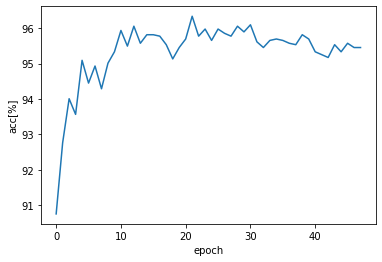

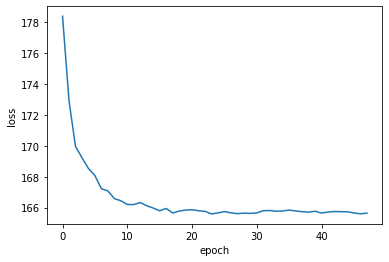

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(range(len(acc_record)), acc_record)
plt.xlabel('epoch')
plt.ylabel('acc[%]')
plt.show()
plt.plot(range(len(loss_test_record)), loss_test_record)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# params = list(snn.named_parameters())
# fc2W = params[0][1][:]
input_idx = 0
input = test_datasets[input_idx]
input = input.float().to(device).unsqueeze(0)
label = test_labels[input_idx]

h2_mem = h2_spike = h2_sumspike = torch.zeros(1, cfg_fc[-1], device=device)
h2_mem_l = torch.zeros(1, max_time, cfg_fc[-1], device=device)
h2_spike_l = torch.zeros(1, max_time, cfg_fc[-1], device=device)
for t in range(max_time): # simulation time steps
    x = input[:,t]
    h2_mem, h2_spike = mem_update(snn.fc2, x, h2_mem, h2_spike, snn.fc_neuron_para)
    h2_sumspike += h2_spike
    h2_mem_l[:,t] = h2_mem
    h2_spike_l[:,t] = h2_spike
print(f'sumspike: {h2_sumspike}')
h2_mem_l = h2_mem_l.permute(0,2,1)
h2_spike_l = h2_spike_l.permute(0,2,1)
# plt.plot(range(max_time), np.array(h2_mem_l[0][0]))

# plt.xlabel('time')
# plt.ylabel('mem')
# plt.show()
for i in range(11):
    plt.plot(range(max_time), h2_mem_l[0][i].detach().numpy(), label=str(i))
plt.plot(range(max_time), np.ones(max_time) * thresh, label='thresh')
plt.plot(range(max_time), np.ones(max_time) * (thresh+lens), label='lr_area')
# plt.legend(loc=' best')

In [ ]:
params = list(snn.named_parameters())
params

sumspike: tensor([[ 0.,  3.,  6.,  0.,  5.,  4.,  2.,  5.,  0.,  4.,  2.,  1.,  2.,  5.,
          1.,  0.,  0.,  6.,  1.,  6.,  3.,  1.,  2.,  0.,  5.,  3.,  3.,  4.,
          7.,  4.,  3.,  4.,  2.,  6.,  1.,  3.,  5.,  0.,  1.,  1.,  3.,  5.,
          3.,  2.,  5.,  6.,  1.,  2.,  0.,  2.,  1.,  6.,  4.,  5.,  1.,  5.,
          2.,  3.,  4.,  8.,  1.,  1.,  0.,  7.,  4.,  0.,  1.,  5.,  1.,  1.,
          1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  3.,  3.,  5.,  3.,  3.,  1.,
          0.,  3.,  0.,  5.,  8.,  0.,  3.,  3.,  0.,  8.,  1.,  5.,  6.,  0.,
          2.,  5.,  5.,  3.,  4.,  0.,  3.,  4.,  3.,  4.,  1.,  2.,  3.,  7.,
          1.,  5.,  3.,  3.,  7.,  0.,  4.,  4.,  3.,  3.,  5.,  4.,  3.,  2.,
          3.,  0.,  2.,  8.,  2.,  1.,  3.,  1.,  3.,  2.,  4.,  3.,  3.,  2.,
          6.,  3.,  2.,  2.,  2.,  6.,  3.,  1.,  4.,  0.,  5.,  5.,  5.,  1.,
          2.,  0.,  4.,  2.,  8.,  4.,  2.,  0.,  2.,  1.,  2.,  3.,  2.,  0.,
          6.,  1.,  1.,  1.,  6.,  4.,  7.

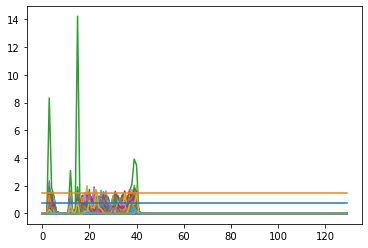

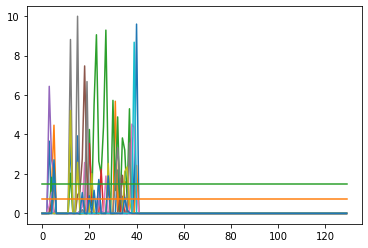

In [26]:
input_idx = 4
input = test_datasets[input_idx]
input = input.float().to(device).unsqueeze(0)
label = test_labels[input_idx]


h1_mem = h1_spike = h1_sumspike = torch.zeros(1, cfg_fc[-2], device=device)
h1_mem_l = torch.zeros(1, max_time, cfg_fc[-2], device=device)
h1_spike_l = torch.zeros(1, max_time, cfg_fc[-2], device=device)
h2_mem = h2_spike = h2_sumspike = torch.zeros(1, cfg_fc[-1], device=device)
h2_mem_l = torch.zeros(1, max_time, cfg_fc[-1], device=device)
h2_spike_l = torch.zeros(1, max_time, cfg_fc[-1], device=device)
for t in range(max_time): # simulation time steps
    x = input[:,t]
    h1_mem, h1_spike = mem_update(snn.fc1, x, h1_mem, h1_spike, snn.fc_neuron_para)
    h1_sumspike += h1_spike
    h1_mem_l[:,t] = h1_mem
    h1_spike_l[:,t] = h1_spike
    h2_mem, h2_spike = mem_update(snn.fc2, h1_spike, h2_mem, h2_spike, snn.fc_neuron_para)
    h2_sumspike += h2_spike
    h2_mem_l[:,t] = h2_mem
    h2_spike_l[:,t] = h2_spike
print(f'sumspike: {h1_sumspike}')
print(f'sumspike: {h2_sumspike}')
h1_mem_l = h1_mem_l.permute(0,2,1)
h1_spike_l = h1_spike_l.permute(0,2,1)
h2_mem_l = h2_mem_l.permute(0,2,1)
h2_spike_l = h2_spike_l.permute(0,2,1)
# plt.plot(range(max_time), np.array(h2_mem_l[0][0]))
# plt.xlabel('time')
# plt.ylabel('mem')
# plt.show()
for i in range(cfg_fc[-2]):
    plt.plot(range(max_time), h1_mem_l[0][i].detach().numpy(), label=str(i))
plt.plot(range(max_time), np.ones(max_time) * thresh, label='thresh')
plt.plot(range(max_time), np.ones(max_time) * (thresh+lens), label='lr_area')
plt.show()
for i in range(cfg_fc[-1]):
    plt.plot(range(max_time), h2_mem_l[0][i].detach().numpy(), label=str(i))
plt.plot(range(max_time), np.ones(max_time) * thresh, label='thresh')
plt.plot(range(max_time), np.ones(max_time) * (thresh+lens), label='lr_area')
# plt.legend(loc='best')
# plt.show()

In [ ]:
input_idx = 0
input = test_datasets[input_idx]
input = input.float().to(device).unsqueeze(0)
label = test_labels[input_idx]

h1_mem = h1_spike = h1_sumspike = torch.zeros(1, cfg_fc[-3], device=device)
h1_mem_l = torch.zeros(1, max_time, cfg_fc[-3], device=device)
h1_spike_l = torch.zeros(1, max_time, cfg_fc[-3], device=device)
h2_mem = h2_spike = h2_sumspike = torch.zeros(1, cfg_fc[-2], device=device)
h2_mem_l = torch.zeros(1, max_time, cfg_fc[-2], device=device)
h2_spike_l = torch.zeros(1, max_time, cfg_fc[-2], device=device)
h3_mem = h3_spike = h3_sumspike = torch.zeros(1, cfg_fc[-1], device=device)
h3_mem_l = torch.zeros(1, max_time, cfg_fc[-1], device=device)
h3_spike_l = torch.zeros(1, max_time, cfg_fc[-1], device=device)
for t in range(max_time): # simulation time steps
    x = input[:,t]
    h1_mem, h1_spike = mem_update(snn.fc1, x, h1_mem, h1_spike, snn.fc_neuron_para)
    h1_sumspike += h1_spike
    h1_mem_l[:,t] = h1_mem
    h1_spike_l[:,t] = h1_spike
    h2_mem, h2_spike = mem_update(snn.fc2, h1_spike, h2_mem, h2_spike, snn.fc_neuron_para)
    h2_sumspike += h2_spike
    h2_mem_l[:,t] = h2_mem
    h2_spike_l[:,t] = h2_spike
    h3_mem, h3_spike = mem_update(snn.fc3, h2_spike, h3_mem, h3_spike, snn.fc_neuron_para)
    h3_sumspike += h3_spike
    h3_mem_l[:,t] = h3_mem
    h3_spike_l[:,t] = h3_spike
print(f'sumspike: {h1_sumspike}')
print(f'sumspike: {h2_sumspike}')
print(f'sumspike: {h3_sumspike}')
h1_mem_l = h1_mem_l.permute(0,2,1)
h1_spike_l = h1_spike_l.permute(0,2,1)
h2_mem_l = h2_mem_l.permute(0,2,1)
h2_spike_l = h2_spike_l.permute(0,2,1)
h3_mem_l = h3_mem_l.permute(0,2,1)
h3_spike_l = h3_spike_l.permute(0,2,1)
# plt.plot(range(max_time), np.array(h2_mem_l[0][0]))
# plt.xlabel('time')
# plt.ylabel('mem')
# plt.show()
for i in range(cfg_fc[-3]):
    plt.plot(range(max_time), h1_mem_l[0][i].detach().numpy(), label=str(i))
plt.plot(range(max_time), np.ones(max_time) * thresh, label='thresh')
plt.plot(range(max_time), np.ones(max_time) * (thresh+lens), label='lr_area')
plt.show()
for i in range(cfg_fc[-2]):
    plt.plot(range(max_time), h2_mem_l[0][i].detach().numpy(), label=str(i))
plt.plot(range(max_time), np.ones(max_time) * thresh, label='thresh')
plt.plot(range(max_time), np.ones(max_time) * (thresh+lens), label='lr_area')
plt.show()
for i in range(cfg_fc[-1]):
    plt.plot(range(max_time), h3_mem_l[0][i].detach().numpy(), label=str(i))
plt.plot(range(max_time), np.ones(max_time) * thresh, label='thresh')
plt.plot(range(max_time), np.ones(max_time) * (thresh+lens), label='lr_area')
# plt.legend(loc='best')
# plt.show()

In [ ]:
params[1][1]

In [ ]:
params = list(snn.named_parameters())
params[0][1][:]

In [ ]:
test_label = test_labels[0]
test_label.size(0)